In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
# compute the absolute path to your project root:
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# insert it at the front of Python’s module search path:
sys.path.insert(0, root)

## Imports

In [86]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import torch
from torch.nn import functional as F
import torch.optim as optim

# Data pipeline
from data_utils.preprocess import (
    load_movielens, clean_and_filter,
    get_user_sequences, split_sequences,
    build_examples, pad_sequences,
    build_user_table, build_movie_table
)

# Dataset wrapper
from data_utils.datasets import MFTrainDataset, FeatureAwareDeepMFDataset

# Model and evaluation
from models.matrix_factorization import MatrixFactorization, DeepMF, FeatureAwareDeepMF
from evaluation import evaluate_ranking_model, evaluate_featureaware_model

#Training
from train_mf import MFTrainer

In [5]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cuda") if torch.cuda.is_available() else device
print("Running on", device)

Running on mps


## Data Preprocessing

In [9]:
data_dir = "../data"
# 1) load & filter
ratings, users, movies = load_movielens(data_dir)
ratings, users, movies = clean_and_filter(ratings, users, movies, rating_threshold=4)

# 2) build per-user sequences & splits
user_seqs   = get_user_sequences(ratings)
user_splits = split_sequences(user_seqs, train_ratio=0.8, val_ratio=0.1)

# 3) global item set
all_movies = set(movies["MovieID"].unique())

# 4) build examples for train/val
train_exs = build_examples(user_splits, all_movies, K=5, split="train")
val_exs   = build_examples(user_splits, all_movies, K=5, split="val")
test_exs   = build_examples(user_splits, all_movies, K=5, split="test")

# 5) pad to fixed length
max_len   = 50
train_exs = pad_sequences(train_exs, max_len=max_len)
val_exs   = pad_sequences(val_exs, max_len=max_len)
test_exs  = pad_sequences(test_exs, max_len=max_len)

In [10]:
num_users = len(users)
num_items = len(movies)

simple_train_ds = MFTrainDataset(train_exs, num_negatives=1)
simple_val_ds   = MFTrainDataset(val_exs,   num_negatives=1)

user_feat, gender_vocab, occ_vocab = build_user_table(users)
movie_genre_vec, movie_year, genre_vocab = build_movie_table(movies)

train_ds = FeatureAwareDeepMFDataset(train_exs, user_feat, movie_genre_vec, movie_year)
val_ds   = FeatureAwareDeepMFDataset(val_exs,   user_feat, movie_genre_vec, movie_year)

In [11]:
def plot_curves(training_metric_data, validation_metric_data, filename = None):
    
    """Plot training and validation metrics over epochs"""
    
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("BPR Loss")
    plt.title("Training & Validation BPR Loss")
    plt.legend(loc='best')
    plt.grid(True)    
    #plt.savefig(filename, dpi=300)

# Training and Eval

## MF

In [51]:
BATCH_SIZE = 2048
LR = 0.008
EMBEDDING_DIM = 10
EPOCHS = 10

train_loader = DataLoader(simple_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(simple_val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

mf = MatrixFactorization(num_users, num_items, embedding_dim=EMBEDDING_DIM).to(device)
optimizer = optim.Adam(mf.parameters(), lr=LR)

trainer = MFTrainer(mf, train_loader, val_loader, optimizer, EPOCHS, device)

Epoch 1/10 | Train Loss: 1.5763  | Val Loss: 1.3022
Epoch 2/10 | Train Loss: 1.0468  | Val Loss: 1.0060
Epoch 3/10 | Train Loss: 0.7846  | Val Loss: 0.8078
Epoch 4/10 | Train Loss: 0.5462  | Val Loss: 0.5812
Epoch 5/10 | Train Loss: 0.3563  | Val Loss: 0.4667
Epoch 6/10 | Train Loss: 0.2832  | Val Loss: 0.4297
Epoch 7/10 | Train Loss: 0.2534  | Val Loss: 0.4145
Epoch 8/10 | Train Loss: 0.2342  | Val Loss: 0.4062
Epoch 9/10 | Train Loss: 0.2179  | Val Loss: 0.4018
Epoch 10/10 | Train Loss: 0.2029  | Val Loss: 0.3996


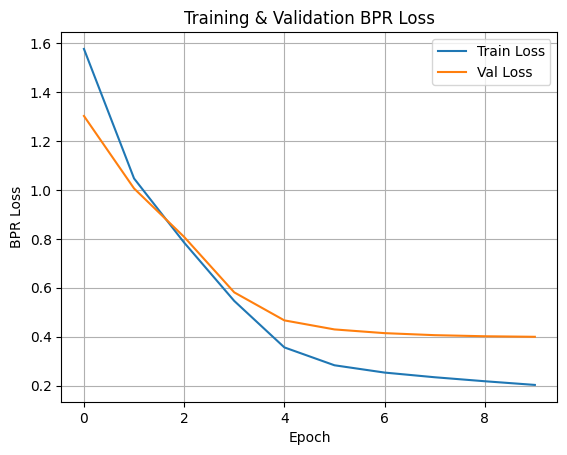

In [52]:
train_losses, val_losses = trainer.fit()
plot_curves(train_losses, val_losses)

In [87]:
metrics = evaluate_ranking_model(
    model=mf,
    user_splits=user_splits,
    global_items=all_movies,
    device=device,
    candidate_size=100,
    k=10
)

print("Evaluation Metrics:")
for name, val in metrics.items():
    print(f"- {name}: {val:.4f}")

Evaluation Metrics:
- Hit@10: 0.4859
- Hit@10 Std: 0.0032
- NDCG@10: 0.2519
- NDCG@10 Std: 0.0010
- MRR: 0.2049
- MRR Std: 0.0010
- MAP: 0.2049
- MAP Std: 0.0010


## Deep MF

In [70]:
BATCH_SIZE = 2048
LR = 0.001
EMBEDDING_DIM = 25
EPOCHS = 10

train_loader = DataLoader(simple_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(simple_val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

deep_mf = DeepMF(num_users, num_items, emb_dim=EMBEDDING_DIM).to(device)
optimizer = optim.Adam(deep_mf.parameters(), lr=LR)

deep_trainer = MFTrainer(deep_mf, train_loader, val_loader, optimizer, EPOCHS, device)

Epoch 1/10 | Train Loss: 0.5910  | Val Loss: 0.5395
Epoch 2/10 | Train Loss: 0.3821  | Val Loss: 0.4330
Epoch 3/10 | Train Loss: 0.3137  | Val Loss: 0.3993
Epoch 4/10 | Train Loss: 0.2933  | Val Loss: 0.3877
Epoch 5/10 | Train Loss: 0.2855  | Val Loss: 0.3825
Epoch 6/10 | Train Loss: 0.2809  | Val Loss: 0.3780
Epoch 7/10 | Train Loss: 0.2779  | Val Loss: 0.3783
Epoch 8/10 | Train Loss: 0.2758  | Val Loss: 0.3775
Epoch 9/10 | Train Loss: 0.2735  | Val Loss: 0.3776
Epoch 10/10 | Train Loss: 0.2720  | Val Loss: 0.3783


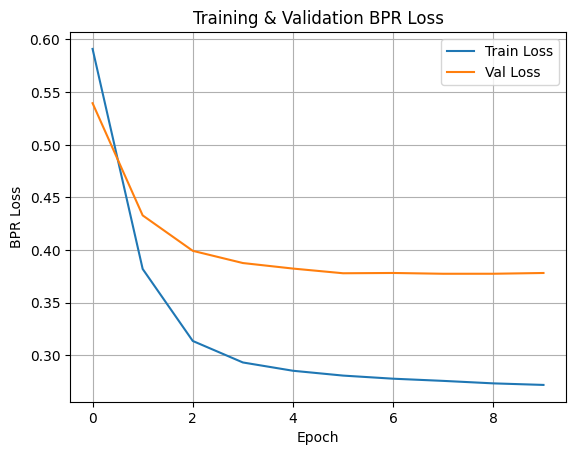

In [71]:
train_losses, val_losses = deep_trainer.fit()
plot_curves(train_losses, val_losses)

In [73]:
metrics = evaluate_ranking_model(
    model=deep_mf,
    user_splits=user_splits,
    global_items=all_movies,
    device=device,
    candidate_size=100,
    k=10
)

print("Evaluation Metrics:")
for name, val in metrics.items():
    print(f"- {name}: {val:.4f}")

Evaluation Metrics:
- Hit@10: 0.5372
- NDCG@10: 0.2933
- MRR: 0.2414
- MAP: 0.2414


## Deep Aware MF

In [81]:
BATCH_SIZE = 1024
LR = 0.01
EMBEDDING_DIM = 32
EPOCHS = 5

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

deep_aware = FeatureAwareDeepMF(
    num_users=len(user_feat),
    num_items=len(movie_genre_vec),
    num_genders=len(gender_vocab),
    num_occs=len(occ_vocab),
    num_genres=len(genre_vocab),
    emb_dim=EMBEDDING_DIM
).to(device)

optimizer = torch.optim.Adam(deep_aware.parameters(), lr=LR)
deep_aware_trainer = MFTrainer(deep_aware, train_loader, val_loader, optimizer, EPOCHS, device)

Epoch 1/5 | Train Loss: 0.3133  | Val Loss: 0.3614
Epoch 2/5 | Train Loss: 0.2382  | Val Loss: 0.3731
Epoch 3/5 | Train Loss: 0.2111  | Val Loss: 0.3673
Epoch 4/5 | Train Loss: 0.1868  | Val Loss: 0.3950
Epoch 5/5 | Train Loss: 0.1658  | Val Loss: 0.3781


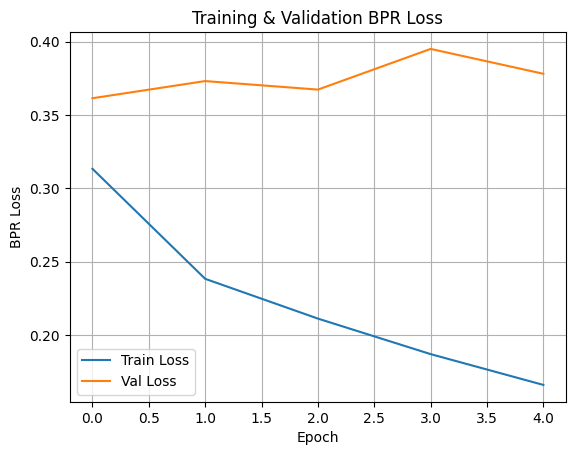

In [82]:
train_losses, val_losses = deep_aware_trainer.fit()
plot_curves(train_losses, val_losses)

In [88]:
metrics = evaluate_featureaware_model(
    deep_aware,
    user_splits,
    set(movies["MovieID"]),
    user_feat,
    movie_genre_vec,
    movie_year,
    device=device
)
print("Evaluation Metrics:")
for name, val in metrics.items():
    print(f"- {name}: {val:.4f}")

Evaluation Metrics:
- Hit@10: 0.5873
- Hit@10 Std: 0.0025
- NDCG@10: 0.3212
- NDCG@10 Std: 0.0019
- MRR: 0.2613
- MRR Std: 0.0019
- MAP: 0.2613
- MAP Std: 0.0019
